# CVAE with different dataset using pytorch

## Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import numpy as np

## Define onehot function

In [2]:
def onehot(x, max_dim):
    # x: list of labels for the input images
    # max_dim: number of possible classes (the size of onehot vector)
    batch_size = x.shape[0] # number of samples in the batch
    vector = torch.zeros(batch_size, max_dim).to(x.device) # to(x.device) ensures the onehot vector tensor 
                                                           # is on the same device (CPU/GPU) as x
    for i in range(batch_size):
        vector[i,x[i]] = 1
    return vector

In [3]:
def coordinate_to_onehot(coord, max_dim=20):
    """Convert a coordinate to a one-hot encoded vector for values in [-10,10] except 0."""
    onehot_x = torch.zeros(max_dim)
    onehot_y = torch.zeros(max_dim)
    if coord[0] < 0:
        onehot_x[int(coord[0]) + 10] = 1
    else:  
        onehot_x[int(coord[0]) + 9] = 1
    
    if coord[1] < 0:
        onehot_y[int(coord[1]) + 10] = 1
    else:  
        onehot_y[int(coord[1]) + 9] = 1
    
    return torch.cat((onehot_x, onehot_y))

In [4]:
coordinate_to_onehot(coord=[1,2], max_dim=20)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.])

## Model structure

In [5]:
class Encoder(torch.nn.Module):
    #encoder, compress data with input_size dimensions to mu and sigma with latent_size dimensions
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(input_size, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.sigma = torch.nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):# x: bs,input_size
        x = F.relu(self.linear(x)) #-> bs,hidden_size
        mu = self.mu(x) #-> bs,latent_size
        sigma = self.sigma(x)#-> bs,latent_size
        return mu,sigma



class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size=40):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)  # No activation here

    def forward(self, x):
        x = F.relu(self.linear1(x))
        logits = self.linear2(x)  # Output logits for x and y
        return logits[:, :20], logits[:, 20:]  # Split into x and y logits


class CVAE(nn.Module):
    def __init__(self, input_size, output_size, condition_size, latent_size, hidden_size):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size + condition_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size + condition_size, hidden_size, output_size)
        
    def forward(self, x, c):  # x: bs, input_size; c: bs, condition_size
        x = torch.cat((x, c), dim=1)  # Concatenate input and condition
        mu, sigma = self.encoder(x)  # mu, sigma: bs, latent_size
        
        # Sample from standard normal distribution
        eps = torch.randn_like(sigma)  # eps: bs, latent_size
        z = mu + eps * sigma  # Reparameterization trick
        
        # Concatenate z with condition
        z = torch.cat((z, c), dim=1)  # z: bs, latent_size + condition_size
        
        # Reconstruct data using decoder
        logits_x, logits_y = self.decoder(z)  # Separate x and y logits
        return logits_x, logits_y, mu, sigma


## Loss function

In [6]:
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
loss_CE = nn.CrossEntropyLoss()
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)

## Model parameters

In [7]:
latent_size = 64 # latent space dimension
hidden_size = 128 # hidden layer dimension
input_size = output_size = 40 # input_size for 2D coordinates (40=20+20)
condition_size = 4

## Training parameters

In [8]:
epochs = 20
batch_size = 32
learning_rate = 1e-3 
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model construction

In [9]:
model = CVAE(input_size, output_size, condition_size, latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
try:
    model.load_state_dict(torch.load(modelname))
    print('[INFO] Load Model complete')
except:
    pass

## Prepare for dataset

Divide four classes according to four quadrants. For each class, there are 200 training data points, 50 testing data points. So the size of the training data is 800, size of the testing data is 200. 

To use "torch.utils.data.DataLoader" to process the data, we want to create a list of training dataset and test dataset. Within each set, there are 800 and 200 data points respectively. For each data point, it is a tuple. Within each tuple (data point), it has two components, the first component is a tensor with a coordinate in 2D plane, while the second component is the label for this point (which quadrant).

In [10]:
import random

train_dataset = []
test_dataset = []

train_set_visualise = []

# Creating train and test datasets with coordinates in the specified ranges
for i in range(4):
    for j in range(500):
        if i == 0:
            coord = torch.tensor([random.randint(1, 10), random.randint(1, 10)])
        elif i == 1:
            coord = torch.tensor([random.randint(-10, -1), random.randint(1, 10)])
        elif i == 2:
            coord = torch.tensor([random.randint(-10, -1), random.randint(-10, -1)])
        else:
            coord = torch.tensor([random.randint(1, 10), random.randint(-10, -1)])
        
        onehot_coord = coordinate_to_onehot(coord)  # Convert to one-hot
        data_point = (onehot_coord, i)  # Store one-hot encoded vector with label
        train_dataset.append(data_point)
        train_set_visualise.append(coord)
    
for i in range(4):
    for j in range(100):
        if i == 0:
            coord = torch.tensor([random.randint(1, 10), random.randint(1, 10)])
        elif i == 1:
            coord = torch.tensor([random.randint(-10, -1), random.randint(1, 10)])
        elif i == 2:
            coord = torch.tensor([random.randint(-10, -1), random.randint(-10, -1)])
        else:
            coord = torch.tensor([random.randint(1, 10), random.randint(-10, -1)])
        
        onehot_coord = coordinate_to_onehot(coord)
        data_point = (onehot_coord, i)
        test_dataset.append(data_point)


In [11]:
print(train_dataset[0][0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.])


In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
print(len(train_loader))

63


### Visualise training dataset

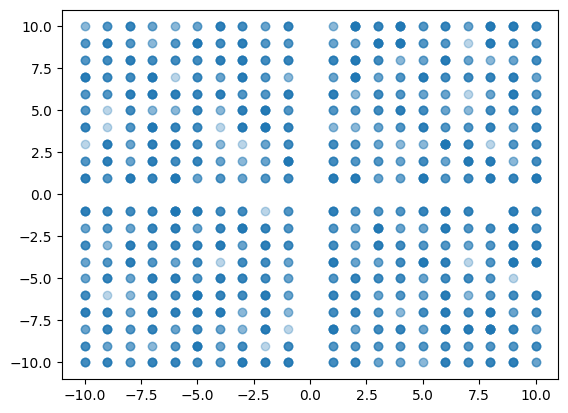

In [14]:
train_set_visualise = list(zip(*train_set_visualise))

plt.scatter(list(train_set_visualise[0]),list(train_set_visualise[1]), alpha=0.3)
plt.show()

## Model training

In [15]:
modelname = 'cvae_pytorch_epoch_{}.pth'  # Use '{}' as a placeholder for epoch number


for epoch in range(epochs):   
    '''model training'''
    #reset loss for each epoch    
    train_loss = 0
    #get data
    for imgs, lbls in tqdm(train_loader, desc=f'[train]epoch:{epoch}'):
        bs = imgs.shape[0]
        imgs = imgs.view(bs, input_size).to(device)

        lbls = onehot(lbls.to(device), condition_size)

        # Forward pass
        logits_x, logits_y, mu, sigma = model(imgs, lbls)

        # Targets for x and y (as categorical indices, not one-hot)
        target_x = imgs[:, :20].argmax(dim=1)
        target_y = imgs[:, 20:].argmax(dim=1)

        # Calculate categorical cross-entropy loss for x and y
        loss_re_x = loss_CE(logits_x, target_x)
        loss_re_y = loss_CE(logits_y, target_y)
        loss_re = loss_re_x + loss_re_y

        # KLD regularization
        loss_norm = loss_KLD(mu, sigma)
        loss = loss_re + loss_norm

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #record total loss
        train_loss += loss.item()
    #print average loss
    print(f'epoch:{epoch}|Train Loss: ',train_loss/len(train_loader.dataset))

    
    # evaluate the model
    model.eval()
    #reset loss for every epoch    
    test_loss = 0
    #get data
    for imgs, lbls in tqdm(test_loader,desc = f'[eval]epoch:{epoch}'):#img: (batch_size,28,28)| lbls: (batch_size,)
        bs = imgs.shape[0]
        imgs = imgs.view(bs,input_size).to(device) #batch_size,input_size(28*28)
        lbls = onehot(lbls.to(device),condition_size)
        
        # In the training loop
        logits_x, logits_y, mu, sigma = model(imgs, lbls)  # Expecting four values now

        # Calculate the categorical cross-entropy losses for x and y separately
        target_x = imgs[:, :20].argmax(dim=1)
        target_y = imgs[:, 20:].argmax(dim=1)

        loss_re_x = loss_CE(logits_x, target_x)
        loss_re_y = loss_CE(logits_y, target_y)
        loss_re = loss_re_x + loss_re_y

        # KLD regularization
        loss_norm = loss_KLD(mu, sigma)
        loss = loss_re + loss_norm
    
        #record total loss
        test_loss += loss.item()
    #print average loss
    print(f'epoch:{epoch}|Test Loss: ',test_loss/len(test_loader.dataset))
    model.train()

    model.eval()
    #sample data from normal distribution
    sample = torch.randn(1,latent_size).to(device)
    
    # Save the model with epoch label
    torch.save(model.state_dict(), modelname.format(epoch))
    print(f"{modelname.format(epoch)} is saved")

[train]epoch:0: 100%|██████████| 63/63 [00:00<00:00, 483.44it/s]


epoch:0|Train Loss:  103.39382427978515


[eval]epoch:0: 100%|██████████| 13/13 [00:00<00:00, 1037.66it/s]


epoch:0|Test Loss:  73.0942529296875
cvae_pytorch_epoch_0.pth is saved


[train]epoch:1: 100%|██████████| 63/63 [00:00<00:00, 640.11it/s]


epoch:1|Train Loss:  59.07520889282227


[eval]epoch:1: 100%|██████████| 13/13 [00:00<00:00, 1329.90it/s]


epoch:1|Test Loss:  48.65790420532227
cvae_pytorch_epoch_1.pth is saved


[train]epoch:2: 100%|██████████| 63/63 [00:00<00:00, 644.81it/s]


epoch:2|Train Loss:  41.22295031738281


[eval]epoch:2: 100%|██████████| 13/13 [00:00<00:00, 1228.01it/s]


epoch:2|Test Loss:  34.58652359008789
cvae_pytorch_epoch_2.pth is saved


[train]epoch:3: 100%|██████████| 63/63 [00:00<00:00, 592.19it/s]


epoch:3|Train Loss:  30.007568969726563


[eval]epoch:3: 100%|██████████| 13/13 [00:00<00:00, 824.35it/s]


epoch:3|Test Loss:  26.069878005981444
cvae_pytorch_epoch_3.pth is saved


[train]epoch:4: 100%|██████████| 63/63 [00:00<00:00, 545.04it/s]


epoch:4|Train Loss:  23.791975387573242


[eval]epoch:4: 100%|██████████| 13/13 [00:00<00:00, 1019.67it/s]


epoch:4|Test Loss:  21.638015899658203
cvae_pytorch_epoch_4.pth is saved


[train]epoch:5: 100%|██████████| 63/63 [00:00<00:00, 269.47it/s]


epoch:5|Train Loss:  19.44251811218262


[eval]epoch:5: 100%|██████████| 13/13 [00:00<00:00, 862.47it/s]


epoch:5|Test Loss:  17.416618003845215
cvae_pytorch_epoch_5.pth is saved


[train]epoch:6: 100%|██████████| 63/63 [00:00<00:00, 560.39it/s]


epoch:6|Train Loss:  15.893895309448242


[eval]epoch:6: 100%|██████████| 13/13 [00:00<00:00, 858.37it/s]


epoch:6|Test Loss:  14.496127319335937
cvae_pytorch_epoch_6.pth is saved


[train]epoch:7: 100%|██████████| 63/63 [00:00<00:00, 587.19it/s]


epoch:7|Train Loss:  13.422316375732422


[eval]epoch:7: 100%|██████████| 13/13 [00:00<00:00, 925.20it/s]


epoch:7|Test Loss:  12.297825241088868
cvae_pytorch_epoch_7.pth is saved


[train]epoch:8: 100%|██████████| 63/63 [00:00<00:00, 639.53it/s]


epoch:8|Train Loss:  11.407372734069824


[eval]epoch:8: 100%|██████████| 13/13 [00:00<00:00, 1229.31it/s]


epoch:8|Test Loss:  10.496683502197266
cvae_pytorch_epoch_8.pth is saved


[train]epoch:9: 100%|██████████| 63/63 [00:00<00:00, 531.92it/s]


epoch:9|Train Loss:  9.386473587036132


[eval]epoch:9: 100%|██████████| 13/13 [00:00<00:00, 830.47it/s]


epoch:9|Test Loss:  8.40104326248169
cvae_pytorch_epoch_9.pth is saved


[train]epoch:10: 100%|██████████| 63/63 [00:00<00:00, 343.59it/s]


epoch:10|Train Loss:  7.883148494720459


[eval]epoch:10: 100%|██████████| 13/13 [00:00<00:00, 773.31it/s]


epoch:10|Test Loss:  7.268959083557129
cvae_pytorch_epoch_10.pth is saved


[train]epoch:11: 100%|██████████| 63/63 [00:00<00:00, 414.36it/s]


epoch:11|Train Loss:  6.86893359375


[eval]epoch:11: 100%|██████████| 13/13 [00:00<00:00, 848.51it/s]


epoch:11|Test Loss:  6.397179193496704
cvae_pytorch_epoch_11.pth is saved


[train]epoch:12: 100%|██████████| 63/63 [00:00<00:00, 454.76it/s]


epoch:12|Train Loss:  6.125083549499512


[eval]epoch:12: 100%|██████████| 13/13 [00:00<00:00, 1121.93it/s]


epoch:12|Test Loss:  5.748509578704834
cvae_pytorch_epoch_12.pth is saved


[train]epoch:13: 100%|██████████| 63/63 [00:00<00:00, 254.13it/s]


epoch:13|Train Loss:  5.527117027282715


[eval]epoch:13: 100%|██████████| 13/13 [00:00<00:00, 707.83it/s]


epoch:13|Test Loss:  5.200333509445191
cvae_pytorch_epoch_13.pth is saved


[train]epoch:14: 100%|██████████| 63/63 [00:00<00:00, 471.33it/s]


epoch:14|Train Loss:  5.034387031555176


[eval]epoch:14: 100%|██████████| 13/13 [00:00<00:00, 784.92it/s]


epoch:14|Test Loss:  4.759318170547485
cvae_pytorch_epoch_14.pth is saved


[train]epoch:15: 100%|██████████| 63/63 [00:00<00:00, 462.66it/s]


epoch:15|Train Loss:  4.627867481231689


[eval]epoch:15: 100%|██████████| 13/13 [00:00<00:00, 1067.15it/s]


epoch:15|Test Loss:  4.390695095062256
cvae_pytorch_epoch_15.pth is saved


[train]epoch:16: 100%|██████████| 63/63 [00:00<00:00, 476.16it/s]


epoch:16|Train Loss:  4.282449829101562


[eval]epoch:16: 100%|██████████| 13/13 [00:00<00:00, 883.03it/s]


epoch:16|Test Loss:  4.070609788894654
cvae_pytorch_epoch_16.pth is saved


[train]epoch:17: 100%|██████████| 63/63 [00:00<00:00, 440.33it/s]


epoch:17|Train Loss:  3.9843643836975096


[eval]epoch:17: 100%|██████████| 13/13 [00:00<00:00, 848.68it/s]


epoch:17|Test Loss:  3.7943135499954224
cvae_pytorch_epoch_17.pth is saved


[train]epoch:18: 100%|██████████| 63/63 [00:00<00:00, 479.55it/s]


epoch:18|Train Loss:  3.7306801795959474


[eval]epoch:18: 100%|██████████| 13/13 [00:00<00:00, 833.82it/s]


epoch:18|Test Loss:  3.562494125366211
cvae_pytorch_epoch_18.pth is saved


[train]epoch:19: 100%|██████████| 63/63 [00:00<00:00, 448.63it/s]


epoch:19|Train Loss:  3.521036403656006


[eval]epoch:19: 100%|██████████| 13/13 [00:00<00:00, 1030.60it/s]

epoch:19|Test Loss:  3.344454441070557
cvae_pytorch_epoch_19.pth is saved


## Latent space plotting

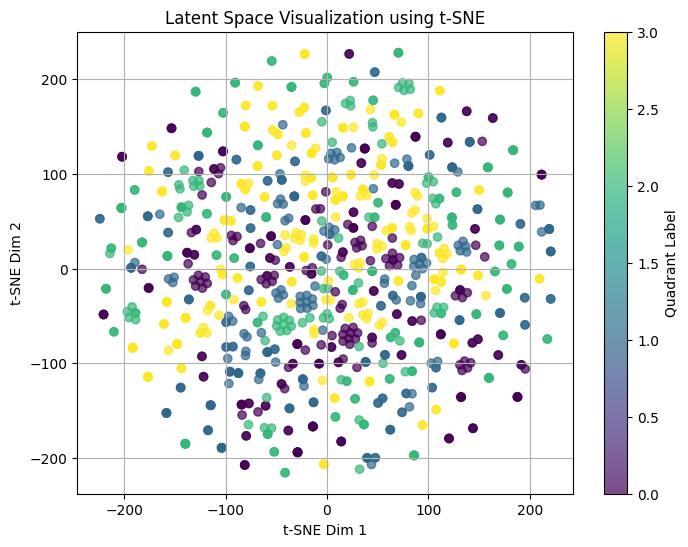

In [16]:
import sklearn
from sklearn.manifold import TSNE

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    # Collect latent vectors for a subset of samples
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            lbls = onehot(lbls.to(device), condition_size)
            
            # Get the latent vectors
            mu, _ = model.encoder(torch.cat((imgs, lbls), dim=1))
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

            if len(latent_vectors) >= num_samples:
                break

    # Convert to numpy array
    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.array(labels)[:num_samples]

    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot the 2D latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels.argmax(axis=1), cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Quadrant Label")
    plt.title("Latent Space Visualization using t-SNE")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()

# Use this function after training the model
plot_latent_space(model, train_loader)

## Visualisation

In [40]:
'''Model prediction''' # use trained model or saved trained model to predict

def generate_sample(i):
    '''
        generate a sample from the latent space with label i
        i: the quadrant index, ranging from 0 to 3
    '''

    sample = torch.randn(1, latent_size).to(device)

    i_number = i * torch.ones(1).long().to(device) 
    condit = onehot(i_number, condition_size)  # One-hot encoding of the label
    inputs = torch.cat((sample, condit), dim=1)  # Concatenate latent sample and condition

    # Use the decoder to generate the new logits
    with torch.no_grad():  # Disable gradient computation for memory efficiency and faster inference
        logits_x, logits_y = model.decoder(inputs)  # Separate x and y logits

    # Get the index for the value of 1 using argmax(dim=1)
    predicted_x_index = logits_x.argmax(dim=1).item()
    predicted_y_index = logits_y.argmax(dim=1).item()

    predicted_coord = []
    if predicted_x_index < 10:
        predicted_x_coord = predicted_x_index - 10
    else:
        predicted_x_coord = predicted_x_index - 9
    
    if predicted_y_index < 10:
        predicted_y_coord = predicted_y_index - 10
    else:
        predicted_y_coord = predicted_y_index - 9
    
    predicted_coord = [predicted_x_coord, predicted_y_coord]
    return predicted_coord

/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_52944/2157409317.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cvae_pytorc

Predicted coordinates: [-9, -2]


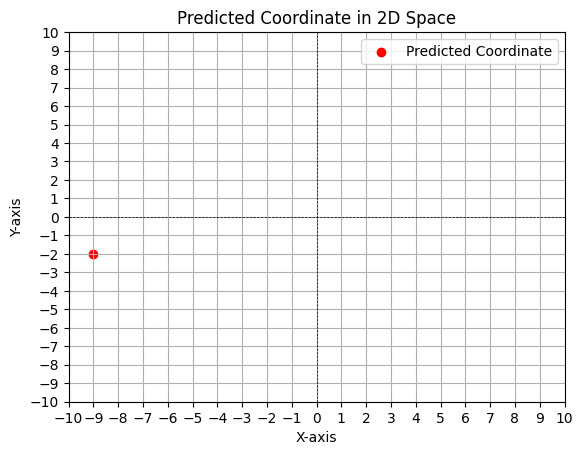

In [18]:
def visualize_one_sample(i):
    '''Visualizing the predicted coordinates of a single sample'''

    predicted_coord = generate_sample(i)
    print(f"Predicted coordinates: {predicted_coord}")

    plt.scatter(predicted_coord[0], predicted_coord[1], c='red', label='Predicted Coordinate')
    plt.xticks(range(-10, 11))
    plt.yticks(range(-10, 11))
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.title("Predicted Coordinate in 2D Space")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.grid()
    plt.show()

visualize_one_sample(i=2)

In [42]:
def visualize_sample_density(quadrant, sample_number):
    '''Visualize sample density using transparency for overlapping points'''
    x_coords = []
    y_coords = []

    for _ in range(sample_number):
        predicted_coord = generate_sample(quadrant)
        x_coord, y_coord = predicted_coord
        x_coords.append(x_coord)
        y_coords.append(y_coord)
    
    # Scatter plot with alpha for density effect
    plt.scatter(x_coords, y_coords, c='red', alpha=0.3, label='Predicted Coordinate')
    
    plt.xticks(range(-11, 11))
    plt.yticks(range(-11, 11))
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.title("Predicted Coordinate Density in 2D Space")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.grid()
    plt.show()

/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_52944/1552252121.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cvae_pytorc

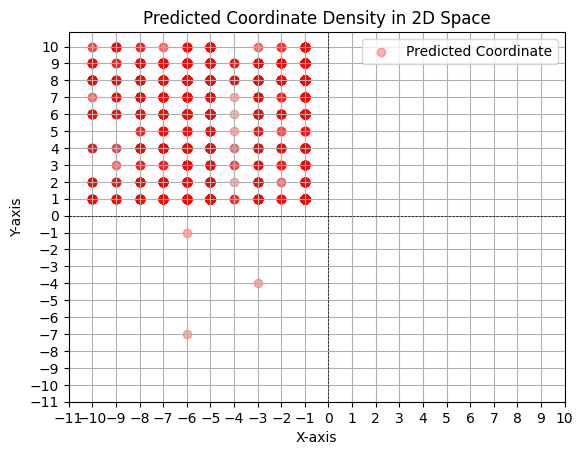

In [65]:
# Load the model weights from 'cvae_pytorch3.pth'
model.load_state_dict(torch.load('cvae_pytorch_epoch_4.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

visualize_sample_density(quadrant=1, sample_number=5000)

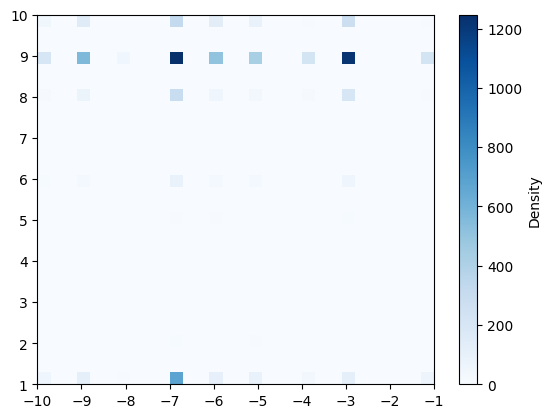

In [20]:
def visualize_sample_density_with_hist2d(quadrant, sample_number, gridsize=30):
    '''visualize samples to see how the samples distribute'''
    x_coords = []
    y_coords = []

    # Generate samples
    for _ in range(sample_number):
        predicted_coord = generate_sample(quadrant)
        x_coord, y_coord = predicted_coord
        x_coords.append(x_coord)
        y_coords.append(y_coord)
    
    plt.hist2d(x_coords, y_coords, bins=gridsize, cmap='Blues')
    # plt.grid()
    plt.colorbar(label='Density')


visualize_sample_density_with_hist2d(quadrant=1, sample_number=8000, gridsize=30)